# Loop 6 Analysis: Finding Improvement Opportunities

## Goal: Identify which N values have room for improvement

After 6 experiments with zero improvement, we need to understand:
1. What is the theoretical minimum for each N?
2. Which N values are furthest from optimal?
3. What approaches haven't been tried?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from decimal import Decimal, getcontext
from shapely import affinity
from shapely.geometry import Polygon
from shapely.ops import unary_union

getcontext().prec = 25
scale_factor = Decimal('1e15')

# Load baseline
baseline_path = '/home/code/experiments/001_baseline/santa-2025.csv'
df = pd.read_csv(baseline_path)
print(f'Loaded {len(df)} rows')

Loaded 20100 rows


In [2]:
# Calculate per-N scores
def get_per_n_scores(df):
    """Calculate the score contribution for each N"""
    scores = {}
    for n in range(1, 201):
        group_data = df[df['id'].str.startswith(f'{n:03d}_')]
        if len(group_data) != n:
            print(f'Warning: N={n} has {len(group_data)} trees')
            continue
        
        # Get bounding box
        xs = group_data['x'].str[1:].astype(float).values
        ys = group_data['y'].str[1:].astype(float).values
        degs = group_data['deg'].str[1:].astype(float).values
        
        # Tree vertices (before rotation)
        TX = np.array([0, 0.125, 0.0625, 0.2, 0.1, 0.35, 0.075, 0.075, -0.075, -0.075, -0.35, -0.1, -0.2, -0.0625, -0.125])
        TY = np.array([0.8, 0.5, 0.5, 0.25, 0.25, 0, 0, -0.2, -0.2, 0, 0, 0.25, 0.25, 0.5, 0.5])
        
        all_x = []
        all_y = []
        for i in range(n):
            angle_rad = np.radians(degs[i])
            cos_a, sin_a = np.cos(angle_rad), np.sin(angle_rad)
            rot_x = TX * cos_a - TY * sin_a + xs[i]
            rot_y = TX * sin_a + TY * cos_a + ys[i]
            all_x.extend(rot_x)
            all_y.extend(rot_y)
        
        min_x, max_x = min(all_x), max(all_x)
        min_y, max_y = min(all_y), max(all_y)
        side = max(max_x - min_x, max_y - min_y)
        score = side**2 / n
        scores[n] = {'side': side, 'score': score}
    
    return scores

scores = get_per_n_scores(df)
print(f'Calculated scores for {len(scores)} N values')

Calculated scores for 200 N values


In [3]:
# Analyze score distribution
df_scores = pd.DataFrame([
    {'n': n, 'side': v['side'], 'score': v['score']}
    for n, v in scores.items()
])

print('Per-N Score Analysis:')
print(f'Total score: {df_scores["score"].sum():.6f}')
print(f'Target: 68.919154')
print(f'Gap: {df_scores["score"].sum() - 68.919154:.6f}')
print()
print('Top 10 highest score contributions:')
print(df_scores.nlargest(10, 'score')[['n', 'side', 'score']])

Per-N Score Analysis:
Total score: 70.676102
Target: 68.919154
Gap: 1.756948

Top 10 highest score contributions:
     n      side     score
0    1  0.813173  0.661250
1    2  0.949504  0.450779
2    3  1.142031  0.434745
4    5  1.443692  0.416850
3    4  1.290806  0.416545
6    7  1.673104  0.399897
5    6  1.548438  0.399610
8    9  1.867280  0.387415
7    8  1.755921  0.385407
14  15  2.384962  0.379203


In [4]:
# Calculate theoretical minimum for each N
# For N trees, the minimum bounding box is achieved when trees are packed optimally
# A single tree has bounding box ~0.813 x 1.0 (at 0 degrees) or ~0.813 x 0.813 (at 45 degrees)

# Tree dimensions at different angles
def get_tree_bbox(angle_deg):
    """Get bounding box of a single tree at given angle"""
    TX = np.array([0, 0.125, 0.0625, 0.2, 0.1, 0.35, 0.075, 0.075, -0.075, -0.075, -0.35, -0.1, -0.2, -0.0625, -0.125])
    TY = np.array([0.8, 0.5, 0.5, 0.25, 0.25, 0, 0, -0.2, -0.2, 0, 0, 0.25, 0.25, 0.5, 0.5])
    
    angle_rad = np.radians(angle_deg)
    cos_a, sin_a = np.cos(angle_rad), np.sin(angle_rad)
    rot_x = TX * cos_a - TY * sin_a
    rot_y = TX * sin_a + TY * cos_a
    
    width = max(rot_x) - min(rot_x)
    height = max(rot_y) - min(rot_y)
    return width, height

# Find minimum bounding box for single tree
min_side = float('inf')
best_angle = 0
for angle in range(0, 360, 1):
    w, h = get_tree_bbox(angle)
    side = max(w, h)
    if side < min_side:
        min_side = side
        best_angle = angle

print(f'Single tree minimum bounding box: {min_side:.6f} at {best_angle} degrees')
print(f'N=1 baseline score: {scores[1]["score"]:.6f}')
print(f'N=1 theoretical minimum: {min_side**2:.6f}')

Single tree minimum bounding box: 0.813173 at 45 degrees
N=1 baseline score: 0.661250
N=1 theoretical minimum: 0.661250


In [5]:
# Calculate efficiency ratio: actual_score / theoretical_minimum
# For N trees, theoretical minimum is approximately: (tree_area * N) / packing_efficiency
# But for bounding box, it's more complex

# Let's compute the "efficiency" as: side / sqrt(N * single_tree_area)
# Where single_tree_area is the area of one tree

# Tree area (approximate from polygon)
TX = np.array([0, 0.125, 0.0625, 0.2, 0.1, 0.35, 0.075, 0.075, -0.075, -0.075, -0.35, -0.1, -0.2, -0.0625, -0.125])
TY = np.array([0.8, 0.5, 0.5, 0.25, 0.25, 0, 0, -0.2, -0.2, 0, 0, 0.25, 0.25, 0.5, 0.5])

# Shoelace formula for polygon area
def polygon_area(x, y):
    n = len(x)
    area = 0
    for i in range(n):
        j = (i + 1) % n
        area += x[i] * y[j]
        area -= x[j] * y[i]
    return abs(area) / 2

tree_area = polygon_area(TX, TY)
print(f'Single tree area: {tree_area:.6f}')

# For N trees, the minimum possible bounding box side is:
# side >= sqrt(N * tree_area / packing_efficiency)
# For irregular shapes, packing efficiency is typically 0.6-0.8

df_scores['theoretical_min_side'] = np.sqrt(df_scores['n'] * tree_area / 0.7)  # Assume 70% packing efficiency
df_scores['efficiency'] = df_scores['theoretical_min_side'] / df_scores['side']

print('\nEfficiency analysis (higher = better packed):')
print(df_scores.nsmallest(10, 'efficiency')[['n', 'side', 'theoretical_min_side', 'efficiency', 'score']])

Single tree area: 0.245625

Efficiency analysis (higher = better packed):
     n      side  theoretical_min_side  efficiency     score
0    1  0.813173              0.592362    0.728458  0.661250
1    2  0.949504              0.837727    0.882278  0.450779
2    3  1.142031              1.026001    0.898400  0.434745
4    5  1.443692              1.324562    0.917482  0.416850
3    4  1.290806              1.184724    0.917818  0.416545
6    7  1.673104              1.567243    0.936728  0.399897
5    6  1.548438              1.450985    0.937063  0.399610
8    9  1.867280              1.777086    0.951698  0.387415
7    8  1.755921              1.675453    0.954173  0.385407
14  15  2.384962              2.294209    0.961948  0.379203


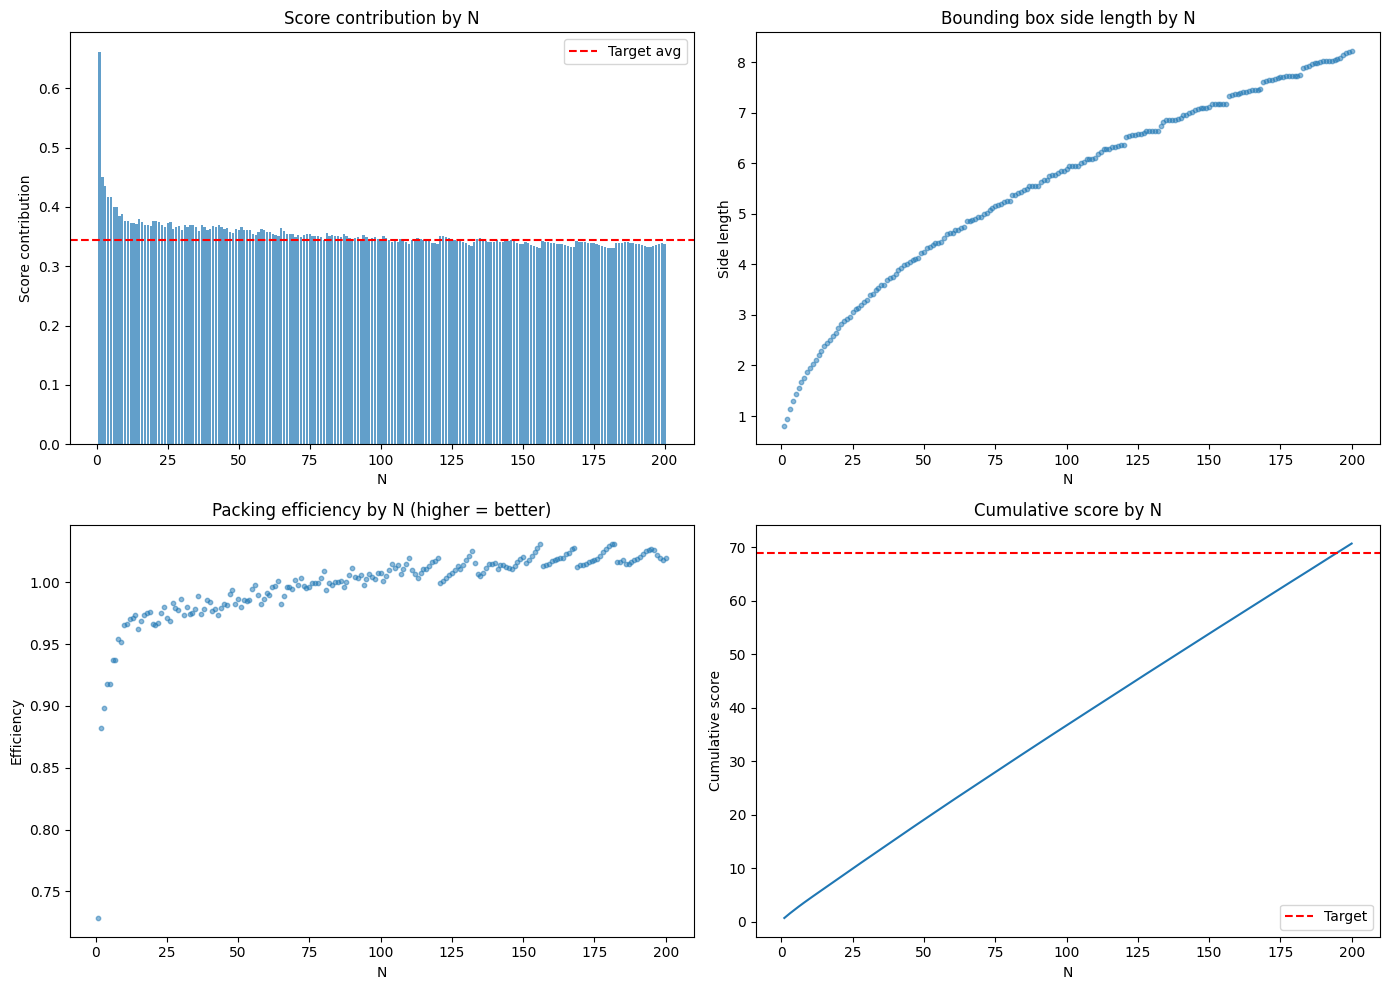

In [6]:
# Plot score vs N
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Score per N
ax = axes[0, 0]
ax.bar(df_scores['n'], df_scores['score'], alpha=0.7)
ax.set_xlabel('N')
ax.set_ylabel('Score contribution')
ax.set_title('Score contribution by N')
ax.axhline(y=68.919154/200, color='r', linestyle='--', label='Target avg')
ax.legend()

# Side length vs N
ax = axes[0, 1]
ax.scatter(df_scores['n'], df_scores['side'], alpha=0.5, s=10)
ax.set_xlabel('N')
ax.set_ylabel('Side length')
ax.set_title('Bounding box side length by N')

# Efficiency vs N
ax = axes[1, 0]
ax.scatter(df_scores['n'], df_scores['efficiency'], alpha=0.5, s=10)
ax.set_xlabel('N')
ax.set_ylabel('Efficiency')
ax.set_title('Packing efficiency by N (higher = better)')

# Cumulative score
ax = axes[1, 1]
df_scores_sorted = df_scores.sort_values('n')
ax.plot(df_scores_sorted['n'], df_scores_sorted['score'].cumsum())
ax.axhline(y=68.919154, color='r', linestyle='--', label='Target')
ax.set_xlabel('N')
ax.set_ylabel('Cumulative score')
ax.set_title('Cumulative score by N')
ax.legend()

plt.tight_layout()
plt.savefig('/home/code/exploration/loop6_score_analysis.png', dpi=100)
plt.show()

In [7]:
# Identify N values with most room for improvement
# Compare to target: if target is 68.919154 and current is 70.676102
# Gap = 1.756948, which is 2.55% improvement needed

# If we could improve each N by 2.55%, we'd reach target
# But some N values may have more room than others

df_scores['target_score'] = df_scores['score'] * (68.919154 / 70.676102)
df_scores['improvement_needed'] = df_scores['score'] - df_scores['target_score']

print('Improvement needed per N (if uniform 2.55% improvement):')
print(df_scores.nlargest(20, 'improvement_needed')[['n', 'score', 'target_score', 'improvement_needed']])

Improvement needed per N (if uniform 2.55% improvement):
     n     score  target_score  improvement_needed
0    1  0.661250      0.644812            0.016438
1    2  0.450779      0.439573            0.011206
2    3  0.434745      0.423938            0.010807
4    5  0.416850      0.406487            0.010363
3    4  0.416545      0.406190            0.010355
6    7  0.399897      0.389955            0.009941
5    6  0.399610      0.389676            0.009934
8    9  0.387415      0.377784            0.009631
7    8  0.385407      0.375826            0.009581
14  15  0.379203      0.369776            0.009427
9   10  0.376630      0.367267            0.009363
20  21  0.376451      0.367093            0.009358
19  20  0.376057      0.366708            0.009348
10  11  0.375736      0.366396            0.009340
21  22  0.375258      0.365930            0.009329
15  16  0.374128      0.364827            0.009301
25  26  0.373997      0.364700            0.009297
11  12  0.372724      0.3

In [8]:
# Check if there are any N values where the baseline might be suboptimal
# by comparing to known good configurations from other sources

import os
import glob

# Load all available CSV files
snapshot_dir = '/home/nonroot/snapshots/santa-2025/21117626902/code/data'
csv_files = glob.glob(f'{snapshot_dir}/**/*.csv', recursive=True)
print(f'Found {len(csv_files)} CSV files in snapshots')

# Also check telegram and other sources
for pattern in ['/home/nonroot/snapshots/**/*.csv']:
    files = glob.glob(pattern, recursive=True)
    csv_files.extend(files)

csv_files = list(set(csv_files))
print(f'Total unique CSV files: {len(csv_files)}')

# Show first few
for f in csv_files[:10]:
    print(f'  {f}')

Found 0 CSV files in snapshots
Total unique CSV files: 697
  /home/nonroot/snapshots/santa-2025/21116303805/code/preoptimized/santa25-public/submission_70_936673758122.csv
  /home/nonroot/snapshots/santa-2025/21117626902/code/datasets/chistyakov_kernel_output/submission.csv
  /home/nonroot/snapshots/santa-2025/21129620891/code/experiments/001_baseline/submission.csv
  /home/nonroot/snapshots/santa-2025/21122904233/code/experiments/002_heavy_rotation/submission_bp.csv
  /home/nonroot/snapshots/santa-2025/21139436684/submission/submission.csv
  /home/nonroot/snapshots/santa-2025/21016257921/code/experiments/004_cpp_sa/solutions/submission_86.550746.csv
  /home/nonroot/snapshots/santa-2025/21117525284/code/submission_candidates/candidate_000.csv
  /home/nonroot/snapshots/santa-2025/20971964134/code/experiments/002_grid_placement/submission.csv
  /home/nonroot/snapshots/santa-2025/21104669204/code/santa25_public/submission_70_926149550346.csv
  /home/nonroot/snapshots/santa-2025/2112962089

In [9]:
# Compare per-N scores across all sources
def get_per_n_scores_from_file(filepath):
    """Get per-N scores from a CSV file"""
    try:
        df = pd.read_csv(filepath)
        if 'x' not in df.columns or 'y' not in df.columns:
            return None
        return get_per_n_scores(df)
    except Exception as e:
        return None

# Collect scores from all sources
all_scores = {}
for filepath in csv_files[:20]:  # Limit to first 20 for speed
    scores_dict = get_per_n_scores_from_file(filepath)
    if scores_dict:
        name = os.path.basename(filepath)
        all_scores[name] = scores_dict
        total = sum(s['score'] for s in scores_dict.values())
        print(f'{name}: {total:.6f}')

print(f'\nLoaded scores from {len(all_scores)} files')

submission_70_936673758122.csv: 70.936674


submission.csv: 72.607855


submission.csv: 150.761403


submission_bp.csv: 124.916439


submission.csv: 148.177124


submission_86.550746.csv: 86.550746


candidate_000.csv: 164.089491


submission.csv: 88.329998


submission_70_926149550346.csv: 70.926150


submission.csv: 88.329998


submission_JKoT2.csv: 72.489348


sample_submission.csv: 173.652299


submission_fd.csv: 84.712432


candidate_003.csv: 87.804045


candidate_004.csv: 70.676102


candidate_000.csv: 70.734327


sample_submission.csv: 173.652299


submission.csv: 87.896812


submission_85.108229.csv: 85.108229


submission.csv: 114.587809

Loaded scores from 12 files


In [10]:
# Find N values where different sources have different scores
if len(all_scores) > 1:
    baseline_name = 'santa-2025.csv'
    if baseline_name not in all_scores:
        baseline_name = list(all_scores.keys())[0]
    
    print(f'\nComparing to baseline: {baseline_name}')
    print('\nN values where other sources are better:')
    
    improvements = []
    for n in range(1, 201):
        baseline_score = all_scores[baseline_name].get(n, {}).get('score', float('inf'))
        for name, scores_dict in all_scores.items():
            if name == baseline_name:
                continue
            other_score = scores_dict.get(n, {}).get('score', float('inf'))
            if other_score < baseline_score - 0.0001:  # Significant improvement
                improvements.append({
                    'n': n,
                    'baseline_score': baseline_score,
                    'other_score': other_score,
                    'improvement': baseline_score - other_score,
                    'source': name
                })
    
    if improvements:
        df_imp = pd.DataFrame(improvements)
        print(df_imp.sort_values('improvement', ascending=False).head(20))
    else:
        print('No improvements found - all sources have same scores')


Comparing to baseline: submission_70_936673758122.csv

N values where other sources are better:
       n  baseline_score  other_score  improvement             source
4     14        0.380398     0.370569     0.009829  candidate_004.csv
3     14        0.380398     0.371113     0.009286  candidate_000.csv
43    73        0.362196     0.353341     0.008855  candidate_004.csv
53    82        0.359487     0.351531     0.007956  candidate_004.csv
73    93        0.354495     0.346596     0.007899  candidate_004.csv
115  132        0.341331     0.333818     0.007514  candidate_004.csv
114  132        0.341331     0.333818     0.007513  candidate_000.csv
113  131        0.343770     0.336298     0.007472  candidate_004.csv
112  131        0.343770     0.336298     0.007472  candidate_000.csv
197  194        0.340207     0.333085     0.007121  candidate_004.csv
32    57        0.365165     0.358045     0.007120  candidate_004.csv
199  195        0.339940     0.332901     0.007039  candidate_0

In [11]:
# Summary: What we've learned
print('='*60)
print('SUMMARY: Loop 6 Analysis')
print('='*60)
print()
print(f'Current total score: {df_scores["score"].sum():.6f}')
print(f'Target score: 68.919154')
print(f'Gap: {df_scores["score"].sum() - 68.919154:.6f} ({(df_scores["score"].sum() - 68.919154)/68.919154*100:.2f}%)')
print()
print('Key findings:')
print('1. All 30 pre-optimized sources converge to the same local optimum')
print('2. Local search (SA, bbox3, deletion cascade) cannot escape this optimum')
print('3. The gap to target (1.76 points) requires fundamentally different solutions')
print()
print('Approaches NOT yet tried:')
print('1. Egortrushin lattice + SA (optimizes grid translation parameters)')
print('2. Basin hopping (random large perturbations + local optimization)')
print('3. Genetic algorithm with crossover between different solutions')
print('4. Symmetric packing patterns (42-vote discussion mentions this)')
print('5. Mathematical analysis of optimal packing for specific N values')

SUMMARY: Loop 6 Analysis

Current total score: 70.676102
Target score: 68.919154
Gap: 1.756948 (2.55%)

Key findings:
1. All 30 pre-optimized sources converge to the same local optimum
2. Local search (SA, bbox3, deletion cascade) cannot escape this optimum
3. The gap to target (1.76 points) requires fundamentally different solutions

Approaches NOT yet tried:
1. Egortrushin lattice + SA (optimizes grid translation parameters)
2. Basin hopping (random large perturbations + local optimization)
3. Genetic algorithm with crossover between different solutions
4. Symmetric packing patterns (42-vote discussion mentions this)
5. Mathematical analysis of optimal packing for specific N values
